# 期中專案: 百貨業實習生日誌情緒分析
**Author:** 周紘樟、鍾君右、林妤姍、陳亞琦<br>
**Date created:** 2021/11/26<br>
**Last modified:** 2021/11/26<br>
希望可以透過實習生日誌的內容，分析他們的情緒變化，與實習狀態。

## 大綱
+ 1. 資料前處理
    + 1.1 基本資料介紹
    + 1.2 日期處體ˇ
    + 1.3 資料清理
    + 1.4 日誌內容斷詞
+ 2. lexicon-base 情緒分析
    + 2.1 準備台大情緒字典
    + 2.2 情緒字典與斷詞結果進行合併
    + 2.3 實習生各自的情緒分析
    + 2.4 依照月份的整體情緒走向
    + 2.5 文字雲
    + 2.6 情緒代表字
    + 2.7 歸類正負面文章
    + 2.8 情緒關鍵字
+ 3. 結論    

In [1]:
# 安裝會使用到的套件
# %pip install wordcloud

In [2]:
# 確認當前工作目錄
%pwd

'c:\\Users\\betty\\D\\資管所\\社群媒體分析\\期中專案'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import re
import jieba
import jieba.analyse
from datetime import datetime
from wordcloud import WordCloud 

In [4]:
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

## 1. 資料前處理
處理實習生日誌的execel檔案，包含日期處理，加上員工編號。

### 1.1 基本資料介紹
- 資料來源: 百貨業的實習生日誌
- 資料集： `raw_data/Meta-1.csv`、`raw_data/Meta-2.csv`
- 資料時間： 2018/04~2021/05

主要分析實習生的情緒變化。本次主要針對以下方向分析：
1. 各個實習生在實習過程鍾的情緒變化？
2. 每個月實習生們的總體情緒走向?
3. 正面和負面時間點上的差異？
4. 正面和負面討論的情緒分數大約多少？

In [5]:
#匯入資料
MetaData1 = pd.read_csv('./raw_data/Meta-1.csv', encoding='UTF-8')
MetaData2 = pd.read_csv('./raw_data/Meta-2.csv', encoding='UTF-8')

In [6]:
print(f"共有 {MetaData1.shape[0]} 篇日誌") #(row,column)
MetaData1.head(3)

共有 354 篇日誌


,artDate,year,intern_id,content
0,12/05-12/11,109,1,開始在本店上班外，還要去別家店支援，每次支援的時候都只會想客群、客人、活動內容，活動內容好難...
1,12/12-12/18,109,1,快到聖誕節了，每間店開始以了聖誕節的氣方以及裝飾，這禮拜不忘要跟客人推薦聖誕節蛋糕，但是自己...
2,12/19-12/25,109,1,這個月開始要衝刺聖誕節蛋糕的預購，發現在一人店根本不知道到底活動內容以及折扣跟優惠，當客人詢...


In [7]:
print(f"共有 {MetaData2.shape[0]} 篇日誌") #(row,column)
MetaData2.head(3)

共有 908 篇日誌


,artDate,year,intern_id,content
0,107年7月8日,107,18,7月開始是大四實習的第一個月，這個禮拜帶了兩個新人去公司上課，希望他們能順利通過考試。除了帶...
1,107年7月15日,107,18,7月開始是大四實習的第一個月，也帶了新人去上課，每天都約了客戶，閒暇的時間也有去內湖開發，內...
2,107年7月22日,107,18,7月開始是大四實習的第一個月，一樣每天都有行程，開發與見客戶。有客戶被抽到抽樣體檢，我帶著客...


### 1.2 日期處理
MetaData1 : 分割日期區間、民國年轉成西元年
MetaData2 : 中文格式轉換、民國年轉成西元年

#### MetaData1
- 調整日期格式:原本"artDate"欄位是日期的區間，所以用'-'分割兩個日期，再取得位於第一個的開始日期

In [8]:
MetaData1['artDate'] = MetaData1.artDate.apply(lambda x: x.split('-')[0])

In [9]:
MetaData1.head(3)

,artDate,year,intern_id,content
0,12/05,109,1,開始在本店上班外，還要去別家店支援，每次支援的時候都只會想客群、客人、活動內容，活動內容好難...
1,12/12,109,1,快到聖誕節了，每間店開始以了聖誕節的氣方以及裝飾，這禮拜不忘要跟客人推薦聖誕節蛋糕，但是自己...
2,12/19,109,1,這個月開始要衝刺聖誕節蛋糕的預購，發現在一人店根本不知道到底活動內容以及折扣跟優惠，當客人詢...


#### MetaData2
- 將"artDate"欄位中的中文字(年、月、日)以"/"符號代替，並刪除字串的前4個字(年份)和倒數第一個"/"，只保留月份和日期

In [10]:
MetaData2['artDate'] = MetaData2.artDate.apply(lambda x: re.sub('[\u4e00-\u9fa5]+', '/', str(x))[4:-1])

In [11]:
MetaData2.head(3)

,artDate,year,intern_id,content
0,7/8,107,18,7月開始是大四實習的第一個月，這個禮拜帶了兩個新人去公司上課，希望他們能順利通過考試。除了帶...
1,7/15,107,18,7月開始是大四實習的第一個月，也帶了新人去上課，每天都約了客戶，閒暇的時間也有去內湖開發，內...
2,7/22,107,18,7月開始是大四實習的第一個月，一樣每天都有行程，開發與見客戶。有客戶被抽到抽樣體檢，我帶著客...


#### MetaData
- 合併MetaData1和MetaData2的資料

In [12]:
MetaData = MetaData1.append(MetaData2,ignore_index=True)

In [13]:
#把"year"欄位的民國年轉成西元年
MetaData['year'] = MetaData.year.apply(lambda x: x + 1911)

In [14]:
#將年份欄位與開始日期合併
MetaData['artDate'] = MetaData['year'].apply(str) + '/' + MetaData['artDate']

In [15]:
#刪除"year"欄位
MetaData = MetaData.drop("year", axis = 1)

In [16]:
MetaData.head()

,artDate,intern_id,content
0,2020/12/05,1,開始在本店上班外，還要去別家店支援，每次支援的時候都只會想客群、客人、活動內容，活動內容好難...
1,2020/12/12,1,快到聖誕節了，每間店開始以了聖誕節的氣方以及裝飾，這禮拜不忘要跟客人推薦聖誕節蛋糕，但是自己...
2,2020/12/19,1,這個月開始要衝刺聖誕節蛋糕的預購，發現在一人店根本不知道到底活動內容以及折扣跟優惠，當客人詢...
3,2020/12/26,1,經歷了上禮拜的腸胃炎，這禮拜沒有完全復原就上工了，雖然生病的時候有發生了一些事情，但是想了想...
4,2021/01/02,1,經歷了聖誕節，接下來重點活動是春節了，春節禮盒、發糕，第一次知道我們原來有在做發糕，而且還有...


### 1.3 資料清理  
- 去除NA值
- 去除不是中文的字詞

In [17]:
# 移除內容為na值的資料
MetaData.dropna(subset = ["content"], inplace=True)

In [18]:
MetaData['content'] = MetaData.content.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '', x))

In [19]:
MetaData.head(3)

,artDate,intern_id,content
0,2020/12/05,1,開始在本店上班外還要去別家店支援每次支援的時候都只會想客群客人活動內容活動內容好難想啊品項只...
1,2020/12/12,1,快到聖誕節了每間店開始以了聖誕節的氣方以及裝飾這禮拜不忘要跟客人推薦聖誕節蛋糕但是自己站店還...
2,2020/12/19,1,這個月開始要衝刺聖誕節蛋糕的預購發現在一人店根本不知道到底活動內容以及折扣跟優惠當客人詢問時...


### 1.4 日誌內容斷詞
中文文集我們使用`jieba`套件進行斷詞與移除停用字

In [65]:
#設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')
#新增自定義字典
# jieba.load_userdict('./dict/user_dict.txt')
#新增stop words
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords= [line.strip() for line in f.readlines()]
# 參數形式手動加入停用字
user_stop = ["這週","真的","希望","禮拜", "東西", "特別", "很快", "一點", "那位"]
for i in user_stop:
    stopWords.append(i)

In [66]:
def getToken(row):
    
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w) > 1] # 篩選不在停用字的字與字元數大於1的字詞
    return seg_list

In [67]:
MetaData['word'] = MetaData.content.apply(getToken)

Building prefix dict from c:\Users\betty\D\資管所\社群媒體分析\期中專案\dict\dict.txt.big ...
Loading model from cache C:\Users\betty\AppData\Local\Temp\jieba.u1113642acd0517a97f06c3927518a439.cache
Loading model cost 0.967 seconds.
Prefix dict has been built successfully.


In [68]:
# 將word欄位展開
MetaData_token = MetaData.explode('word') 

In [69]:
#轉換日期格式
MetaData_token['artDate'] = pd.to_datetime(MetaData_token['artDate'], format="%Y/%m/%d")

In [70]:
MetaData_token.head(3)

,artDate,intern_id,content,word
0,2020-12-05,1,開始在本店上班外還要去別家店支援每次支援的時候都只會想客群客人活動內容活動內容好難想啊品項只...,本店
0,2020-12-05,1,開始在本店上班外還要去別家店支援每次支援的時候都只會想客群客人活動內容活動內容好難想啊品項只...,上班
0,2020-12-05,1,開始在本店上班外還要去別家店支援每次支援的時候都只會想客群客人活動內容活動內容好難想啊品項只...,別家


In [71]:
#計算每天不同字的詞頻
word_count = MetaData_token.groupby(['artDate','word'],as_index=False).size()
word_count.sort_values(by=['size'], ascending=False,inplace=True)  #排序
word_count = word_count[word_count['size']>3]  #過濾出現太少次的字
word_count.head()

,artDate,word,size
18500,2019-05-01,工作,104
17182,2019-04-30,客人,91
15349,2019-04-19,客人,80
18431,2019-05-01,客人,70
18454,2019-05-01,實習,54


In [72]:
# 新增artMonth欄位記錄每月的字詞
MetaData_token['artMonth'] = MetaData_token.artDate.apply(lambda x: x.strftime("%Y-%m"))
MetaData_token['artMonth']

0       2020-12
0       2020-12
0       2020-12
0       2020-12
0       2020-12
         ...   
1261    2019-04
1261    2019-04
1261    2019-04
1261    2019-04
1261    2019-04
Name: artMonth, Length: 50783, dtype: object

In [73]:
#計算每月不同字的詞頻
word_count = MetaData_token.groupby(['artMonth','word'],as_index=False).size()
word_count.sort_values(by=['size'], ascending=False,inplace=True)  #排序
word_count = word_count[word_count['size']>3]  #過濾出現太少次的字
word_count.head()

,artMonth,word,size
10943,2019-04,客人,213
7851,2018-12,客人,135
13373,2019-05,工作,116
3468,2018-09,客人,110
817,2018-07,實習,102


## 2. lexicon-base 情緒分析
進行基於情緒字典的情緒分析，首先需要準備情緒字典後再將字典與斷詞後的文章進行合併

### 2.1 準備台大字典  
- 分為正向情緒與負向情緒

In [74]:
filepath = ['negative','positive']
d_ntusd = []
for file in filepath:
    filename = f"./dict/NTUSD/{file}.txt"
    with open(filename, 'r', encoding='UTF-8-sig') as f:
        d_ntusd.append([f.read().split("\n"),file])

In [75]:
df_ntusd = pd.DataFrame(d_ntusd,columns = ['word','sentiments']).explode('word',ignore_index = True)
df_ntusd

,word,sentiments
0,幹,negative
1,一下子爆發,negative
2,一下子爆發的一連串,negative
3,一巴掌,negative
4,一再,negative
...,...,...
11079,戀戀,positive
11080,驚喜,positive
11081,讚許,positive
11082,讚賞,positive


### 2.2 情緒字典與斷詞結果進行合併

In [76]:
# data_datecount = pd.DataFrame(MetaData.groupby('artDate').size(),columns = ['count'])
# plt.figure(figsize=(6,4))   # 顯示圖框架大小 (寬,高)
# plt.style.use("ggplot")     # 使用ggplot主題樣式

# plt.title('每天的發文數量')
# plt.xlabel('artDate')
# plt.xticks(rotation= 45, fontsize=11)
# plt.plot(data_datecount.index, data_datecount['count'].tolist())

### 2.3 正負向情緒分數聲量折線圖圖
分別畫出文集中，正向（positive）與負向（negative）情緒的折線圖

In [77]:
#日誌和與台大情緒字典做合併
data_ntusd = pd.merge(MetaData_token, df_ntusd, on=['word'],how='left')

#算出每月情緒總和(sentiment_count)
sentiment_count = data_ntusd.groupby(['artMonth','sentiments'],as_index=False).size()
sentiment_count.head(10)

,artMonth,sentiments,size
0,2018-04,negative,19
1,2018-04,positive,10
2,2018-05,negative,21
3,2018-05,positive,40
4,2018-07,negative,294
5,2018-07,positive,609
6,2018-08,negative,147
7,2018-08,positive,254
8,2018-09,negative,309
9,2018-09,positive,469


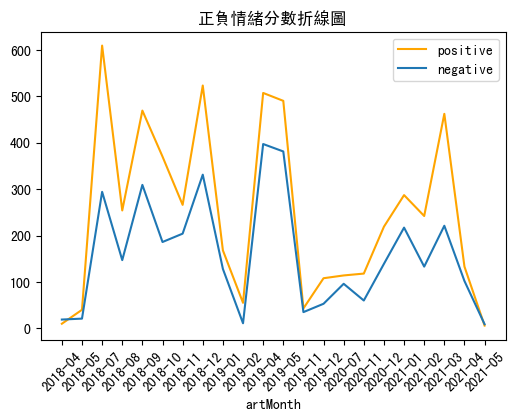

In [78]:
p = sentiment_count[sentiment_count['sentiments']=='positive']
n = sentiment_count[sentiment_count['sentiments']=='negative']

plt.figure(figsize=(6,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式

plt.title('正負情緒分數折線圖')
plt.plot(p['artMonth'].tolist(), p['size'], label='positive',color="orange")
plt.plot(n['artMonth'].tolist(), n['size'], label='negative')
plt.xticks(rotation= 45, fontsize=10)
plt.legend() #顯示圖例
#plt.axvline(x='2021-03-18', color="red", ls="-")
plt.xlabel('artMonth')
plt.show()

### 2.4 正負向情緒分數比例折線圖圖

In [79]:
sentiment_count_r = sentiment_count.assign(ratio = sentiment_count.groupby(['artMonth'], as_index=False)
                                           .apply(lambda x: x['size'] / sum(x['size'])).reset_index(level=0, drop=True))

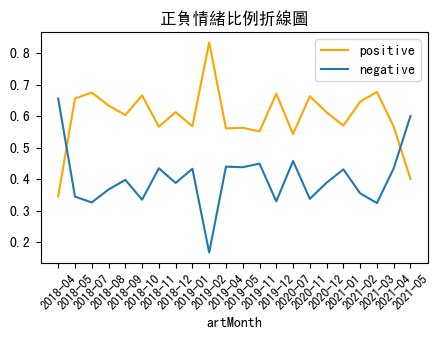

In [80]:
# sentiment_count_r = sentiment_count_r[sentiment_count_r['artDate'] > '2021/03/13']
p = sentiment_count_r[sentiment_count_r['sentiments']=='positive']
n = sentiment_count_r[sentiment_count_r['sentiments']=='negative']

plt.figure(figsize=(5,3))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式

plt.title('正負情緒比例折線圖')
plt.plot(p['artMonth'].tolist(), p['ratio'], label='positive',color="orange")
plt.plot(n['artMonth'].tolist(), n['ratio'], label='negative')
plt.xticks(rotation= 45, fontsize=9)
plt.legend() #顯示圖例
# plt.axvline(x=datetime.strptime('2021-03-18', "%Y-%m-%d"), color="red", ls="-")
# plt.axvline(x=datetime.strptime('2021-03-19', "%Y-%m-%d"), color="red", ls="-")
# plt.axvline(x=datetime.strptime('2021-03-25', "%Y-%m-%d"), color="red", ls="-")
# plt.axvline(x=datetime.strptime('2021-03-26', "%Y-%m-%d"), color="red", ls="-")
plt.xlabel('artMonth')
plt.show()

### 2.5 文字雲
針對不同月分畫出該月的文字雲，如果文字雲中的字詞大小越大，代表出現頻率越高

#### 整體的文字雲

In [81]:
def Wc_dict1(df, countB, countS):
    wc_df = (df.query('size < @countB')# 篩選最大數量
             .query('size > @countS')# 篩選最小數量
             .sort_values('size', ascending=False))
    wc_dict = dict(zip(wc_df['word'], wc_df['size'])) #建立成dictionary
    
    return wc_dict

In [82]:
def Wc_dict2(df, Month, countB, countS):
    wc_df = (df.query('artMonth == @Month') # 篩選日期
             .query('size < @countB')# 篩選最大數量
             .query('size > @countS')# 篩選最小數量
             .sort_values('size', ascending=False))
    wc_dict = dict(zip(wc_df['word'], wc_df['size'])) #建立成dictionary
    
    return wc_dict
    

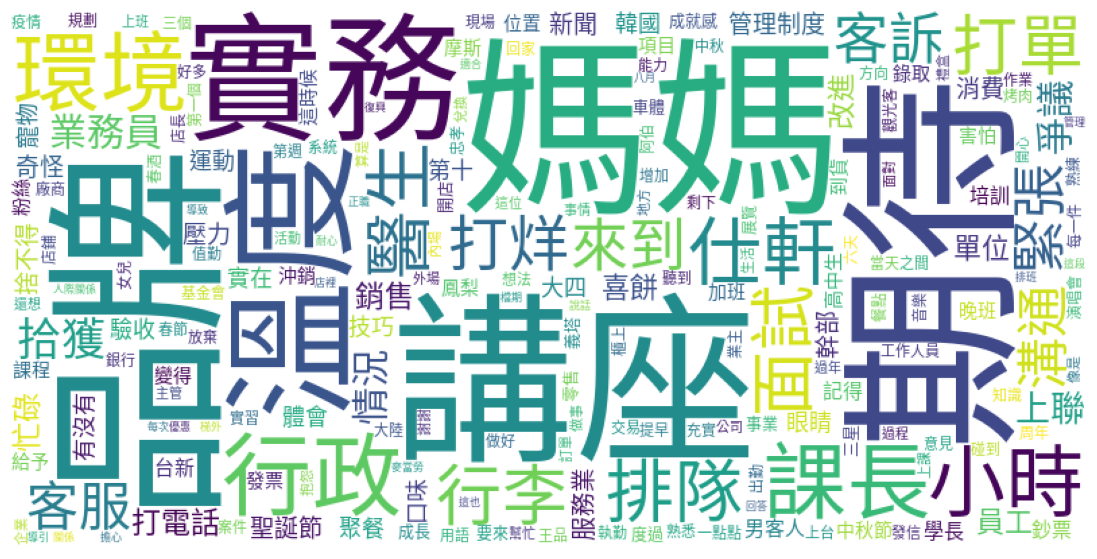

In [83]:
dict_all = Wc_dict1(word_count,450,5)

font = './SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_all)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

### 月文字雲


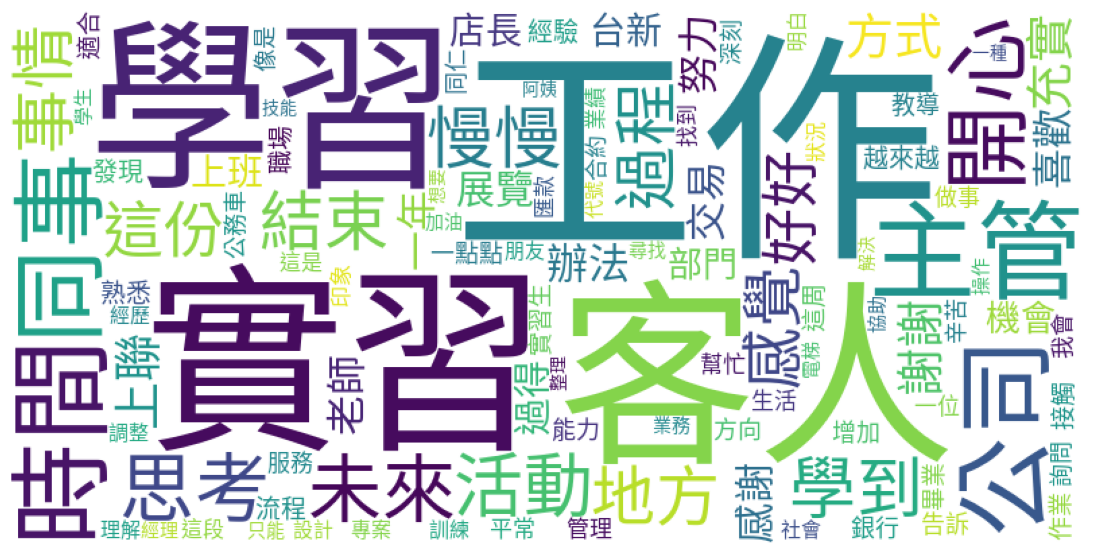

In [84]:
dict_03 = Wc_dict2(word_count,"2021-03",450,5)

font = './SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_03)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

### 2.6 情緒代表字
從整個文集中計算出正負向情緒字的出現詞頻，並找出情緒的代表字

In [85]:
sentiment_sum = (word_count.merge(df_ntusd, on='word')
                 .groupby(['word', 'sentiments'], as_index=False)
                 .agg({'size': 'sum'}))
sentiment_sum = sentiment_sum.sort_values(by=['size'], ascending=False)  #排序
sentiment_sum.head()

,word,sentiments,size
42,學習,positive,389
29,喜歡,positive,222
139,開心,positive,155
59,感謝,positive,130
114,經驗,positive,125


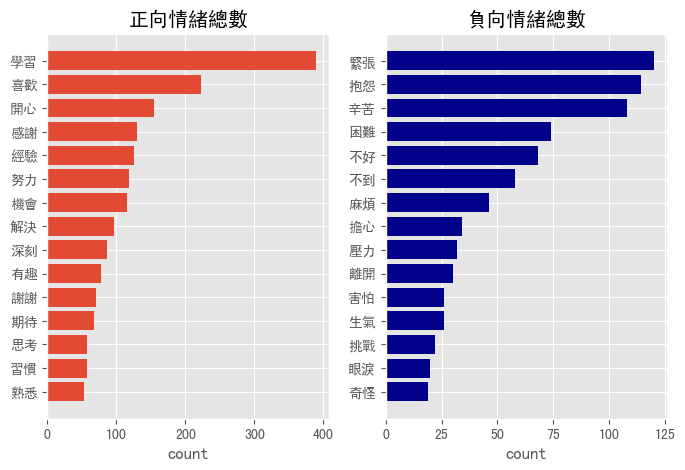

In [86]:
p_sum = sentiment_sum[sentiment_sum["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = sentiment_sum[sentiment_sum["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

另外，也可以依據不同月分觀察情緒代表字的變化

In [88]:
sentiment_date_sum = (word_count.merge(df_ntusd, on='word')
                 .groupby(['artMonth', 'word', 'sentiments'], as_index=False)
                 .agg({'size': 'sum'}))

#篩選月份
sentiment_03 = sentiment_date_sum[sentiment_date_sum['artMonth']=="2021-03"].sort_values(by=['size'], ascending=False)
sentiment_03.head()

,artMonth,word,sentiments,size
399,2021-03,學習,positive,42
396,2021-03,喜歡,positive,22
401,2021-03,感謝,positive,22
429,2021-03,開心,positive,19
400,2021-03,思考,positive,19


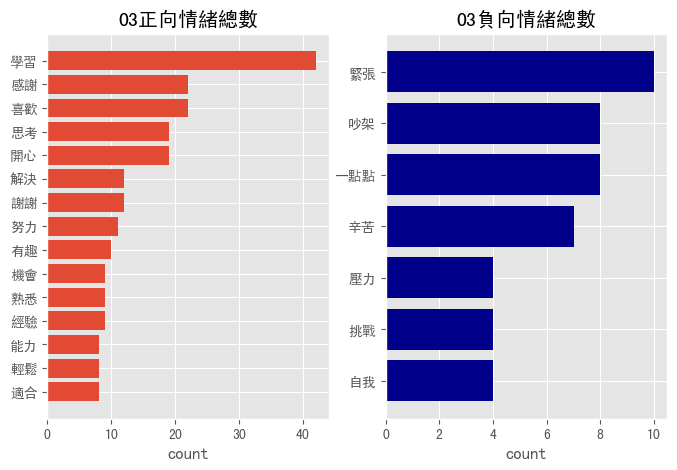

In [89]:
p_sum = sentiment_03[sentiment_03["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = sentiment_03[sentiment_03["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('03正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('03負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

### 2.7 歸類正負面文章
- 之前的情緒分析大部分是全部的詞彙加總，接下來將正負面情緒的文章分開，看看能不能發現一些新的東西。  
- 接下來歸類文章，將每一篇文章正負面情緒的分數算出來，然後大概分類文章屬於正面還是負面。

In [93]:
article_type = (MetaData_token.merge(df_ntusd, on='word')
                .groupby(['content', 'sentiments'], as_index=False)
                .size()
                .pivot_table(index='content', columns='sentiments', values='size', fill_value=0)
                .reset_index(['content'])
               )
article_type.head()

sentiments,content,negative,positive
0,一下就下班了不只電梯爆炸服務台也人很多從上班忙到休息時間拾獲物都沒時間,1,0
1,一個學期好快就過了剛進來舊振南實習的時候還覺得想那麼多幹嘛時間還久嘛但一眨眼一學期半年就過去...,3,3
2,一個月真的過的挺快的新年的第一個月要過完了呢也代表快要迎接過年的長假來囉月底又開始越來越悠閒...,5,2
3,一整個晚上跑了整個小巨蛋會場沒有停下只因為違規的觀眾太多沒有時間停下來喝水但也因為要將違規者...,2,4
4,一整天都是站梯外的導引對我來說導引比開電梯還要不容易因為導引承擔很多東西像是顧客的情緒等等但...,0,2


In [94]:
article_type['type'] = article_type.apply(lambda x: 'positive' if x['positive'] > x['negative'] else 'negative',axis=1)
article_type.groupby('type', as_index=False).size()

,type,size
0,negative,418
1,positive,668


### 正負情緒文章數量統計圖

In [96]:
article_type_Month = article_type.merge(MetaData_token.loc[:,["content", "artMonth"]], how = 'left', on = 'content')
article_type_Month = article_type_Month.groupby(['artMonth','type'], as_index=False).size()
#article_type_date

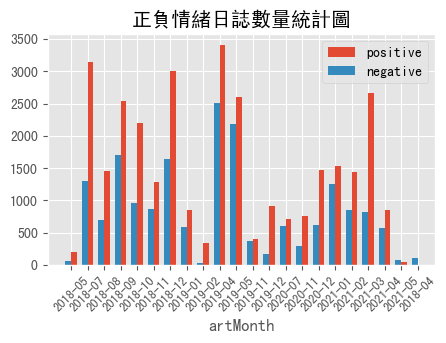

In [98]:
ap = article_type_Month[(article_type_Month["type"]=="positive")]
an = article_type_Month[(article_type_Month["type"]=="negative")]

plt.figure(figsize=(5,3))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.title('正負情緒日誌數量統計圖')
plt.xlabel('artMonth')
plt.bar(ap['artMonth'],ap['size'],align="edge",width=0.35,label="positive")
plt.bar(an['artMonth'],an['size'],align="edge",width=-0.35,label="negative")
plt.legend()
plt.xticks(rotation= 45, fontsize=9)
plt.xlabel('artMonth')
plt.show()

### 2.8 情緒關鍵字
把正面和負面的文章挑出來，並和斷詞結果合併

In [100]:
positive_article = article_type[article_type["type"]=="positive"].merge(MetaData_token, how = 'left', on = 'content')
negative_article = article_type[article_type["type"]=="negative"].merge(MetaData_token, how = 'left', on = 'content')

### 情緒關鍵字:負面情緒文章

In [101]:
negative_article = (negative_article.merge(df_ntusd, on='word')
                    .groupby(['word', 'sentiments'], as_index=False)
                    .size()
                    .sort_values('size', ascending = False))

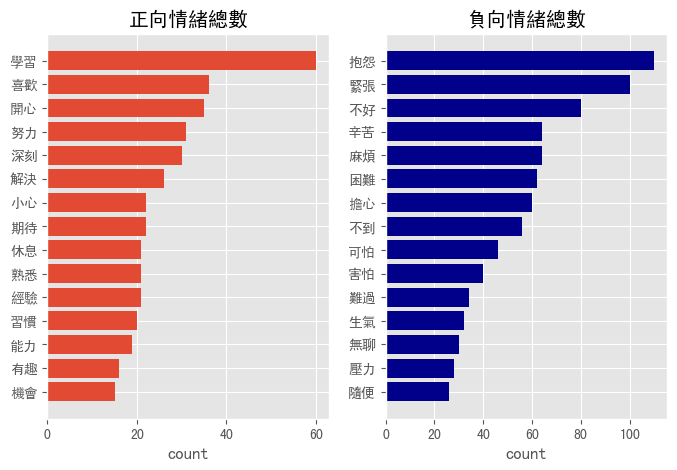

In [102]:
p_sum = negative_article[negative_article["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = negative_article[negative_article["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

### 情緒關鍵字:正面情緒文章

In [103]:
positive_article = (positive_article.merge(df_ntusd, on='word')
                    .groupby(['word', 'sentiments'], as_index=False)
                    .size()
                    .sort_values('size', ascending = False))

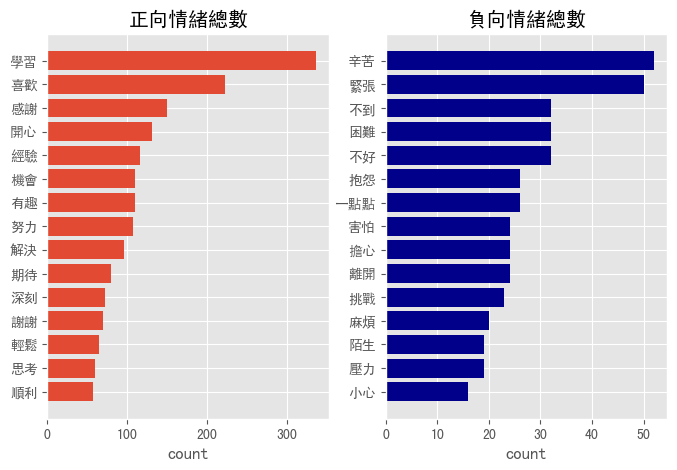

In [104]:
p_sum = positive_article[positive_article["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = positive_article[positive_article["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()